**0. OBJECTO EN PYTHON  QUE ENCAPSULA EL LABORATORIO:  Class analisis_entrada**<BR>
Author: Eduardo Toledo

In [1]:
import math
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
from funciones_qq_pp_plot_V2 import *
from funciones_KS_test import *

class analisis_entrada:

  def __init__(self):
    self._repositorio = "Datos-Caso-III.xlsx"
    self._tables = {"LlegadaAviones": "DatosLlegadaAviones",
                   "Biometrico": "TiempoDeServicioBiométrico",
                   "Pasajeros": "DatosPasajeros"}
    self._df_lleg_aviones = pd.read_excel(self._repositorio, sheet_name=self._tables['LlegadaAviones'])
    self._df_svc_biometrico = pd.read_excel(self._repositorio, sheet_name=self._tables['Biometrico'])
    self._df_pasajeros = pd.read_excel(self._repositorio, sheet_name=self._tables['Pasajeros'])

  def get_df_llegada_aviones(self):
      return self._df_lleg_aviones;

  def get_df_svc_biometrico(self):
      return self._df_svc_biometrico;

  def get_df_pasajeros(self):
      return self._df_pasajeros;

  def calcular_franja(self,hora):
    if 6 <= hora < 11:
        return "6:00 am - 11:00 am"
    elif 11 <= hora < 15:
        return "11:00 am - 3:00 pm"
    elif 15 <= hora < 21:
        return "3:00 pm - 9:00 pm"
    else:
        return "9:00 pm - 6:00 am"

  def tiempo_entre_arribos_por_franjas(self):
    self._df_lleg_aviones = self._df_lleg_aviones.sort_values(by='Fecha de Llegada', ascending=True)
    # Convertir la columna "Fecha de Llegada" a formato datetime
    self._df_lleg_aviones['Fecha de Llegada'] = pd.to_datetime(self._df_lleg_aviones['Fecha de Llegada'])
    # Crear una columna con las franjas horarias correspondientes
    self._df_lleg_aviones['Franja Horaria'] =  self._df_lleg_aviones['Fecha de Llegada'].apply(lambda x: self.calcular_franja(x.hour))
    self._df_lleg_aviones['Tiempo entre Arribos Min'] =  self._df_lleg_aviones['Fecha de Llegada'].diff().dt.total_seconds()/60

    #self._df_lleg_aviones['Tiempo entre Arribos Min'].fillna(0, inplace=True)
    self._df_lleg_aviones.dropna(inplace=True)
    return  self._df_lleg_aviones

  def estadisticas_descript_tiempo_llegada_aviones_franja(self,  franja):
    df_franja= self._df_lleg_aviones[ self._df_lleg_aviones['Franja Horaria']== franja]
    print(franja)
    print(df_franja.shape)
    print(df_franja['Tiempo entre Arribos Min'].describe())

  def histogramas_tiempo_llegadas_aviones_franjas(self):
    fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharex=True)
    fig.suptitle('Tiempo Arribos en Min por Franjas')

    franjas=["6:00 am - 11:00 am","11:00 am - 3:00 pm","3:00 pm - 9:00 pm","9:00 pm - 6:00 am"]
    plot_num=0
    for franja in franjas:
      df_franja= self._df_lleg_aviones[ self._df_lleg_aviones['Franja Horaria']== franja]
      axes[int(plot_num/2),int(plot_num % 2)].set_title(franja)
      sns.histplot( data= df_franja,
                 x='Tiempo entre Arribos Min',
                 bins=int(math.sqrt(df_franja.shape[0])),
                 kde=True, ax= axes[int(plot_num/2),int(plot_num % 2)])
      plot_num= plot_num+1

  def ksetest_llegada_aviones_franja(self, franja,dist_teorica, parametros=()):
    df= self._df_lleg_aviones[ self._df_lleg_aviones['Franja Horaria']== franja]['Tiempo entre Arribos Min']
    self.kolmogorov_test(df, dist_teorica, parametros)

  def ksetest_servicio_biometrico(self, dist_teorica, parametros=()):
      df= self._df_svc_biometrico['Tiempo de servicio (minutos)']
      self.kolmogorov_test(df, dist_teorica, parametros)

  def kolmogorov_test(self, df, dist_teorica, parametros=()):
      test_statistic, p_value = kstest(df.to_numpy() , dist_teorica,parametros)
      print("Estadística de prueba:", test_statistic)
      print("Valor p:", p_value)

      # Comparar el valor p con un nivel de significancia (ejemplo: 0.05)
      nivel_significancia = 0.05
      if p_value < nivel_significancia:
        print("Rechazar la hipótesis nula: los datos no siguen la distribución teórica.")
      else:
        print("No se puede rechazar la hipótesis nula: los datos siguen la distribución teórica.")

  def tiempo_servicio_biometrico(self):
       # Leer tiempo de servicio biometrico desde el repositorio
      return self._df_svc_biometrico

  def histograma_tiempo_servicio_biometrico(self):
    sns.histplot( data= self._df_svc_biometrico,
                 x='Tiempo de servicio (minutos)',
                 bins=int(math.sqrt(self._df_svc_biometrico.shape[0])),
                 kde=True)

  def estadisticas_descript_tiempo_servicio_biometrico(self):
    print(self._df_svc_biometrico["Tiempo de servicio (minutos)"].describe())

  def visualizacion_observado_teorico_biometricos(self):
    df = self._df_svc_biometrico.copy()
    resultado =self.visualizacion_observado_teorico(df,
                                    "Tiempo de servicio (minutos)",
                                    "Tiempo Servicio Biometrico")
    return resultado

  def visualizacion_observado_teorico_por_franjas(self, franja):
    df = self._df_lleg_aviones.copy()
    df_franja = df[df['Franja Horaria']== franja]
    resultado =self.visualizacion_observado_teorico(df_franja,
                                    "Tiempo entre Arribos Min",
                                    "Tiempo Arribos en Min por Franjas "+ franja)
    return resultado

  def visualizacion_observado_teorico(self, df, columna,titulo ):
    resultado= {'normal': {'media':0, 'desvesta': 0},
                'lognormal': {'media':0, 'desvesta': 0},
                'exponencial':{'tasa':0},
                'uniforme':{'minimo':0, 'maximo':0},
                'triangular':{'minimo':0, 'moda':0,'maximo':0},
                'gamma':{'media':0, 'varianza':0},
                'weibull':{'forma':0, 'escala':0}}

    fig, axes = plt.subplots(7,3, figsize=(20,35))
    axes = axes.ravel()
    fig.suptitle(titulo)
    serie=df[columna]
    n= df.shape[0]
    media_normal, desvesta_normal=PP_QQ_plot_normal(data=serie,media="estimado",desvesta="estimado", ax1=axes[0], ax2=axes[1])
    ajuste_observada_teorica(dist='normal', data=serie, media=media_normal, desvesta=desvesta_normal, tamanio_muestra=n,
                          ax=axes[2])
    resultado['normal']['media']= media_normal
    resultado['normal']['desvesta']= desvesta_normal

    try:
      media_lognormal, desvesta_lognormal=PP_QQ_plot_lognormal(df[columna],media="estimado",desvesta="estimado",
                            ax1=axes[3], ax2=axes[4])
      ajuste_observada_teorica(dist='lognormal', data=serie, media=media_lognormal, desvesta=desvesta_lognormal, tamanio_muestra=n,
                            ax=axes[5])
      resultado['lognormal']['media']= media_lognormal
      resultado['lognormal']['desvesta']= desvesta_lognormal
    except:
      pass

    tasa=PP_QQ_plot_exponential(df[columna],tasa="estimado",
                            ax1=axes[6], ax2=axes[7])
    ajuste_observada_teorica(dist='exponencial', data=serie, tasa=tasa, tamanio_muestra=n,
                            ax=axes[8])
    resultado['exponencial']['tasa'] = tasa
    minimo, maximo=PP_QQ_plot_uniform(df[columna],minimo="estimado",maximo="estimado",
                            ax1=axes[9], ax2=axes[10])
    ajuste_observada_teorica(dist='uniforme', data=serie, minimo=minimo, maximo=maximo, tamanio_muestra=n,
                            ax=axes[11])
    resultado['uniforme']['minimo']= minimo
    resultado['uniforme']['maximo']= maximo

    minimo, moda, maximo=PP_QQ_plot_triangular(df[columna],minimo="estimado",maximo="estimado",
                            ax1=axes[12], ax2=axes[13])
    ajuste_observada_teorica(dist='triangular', data=serie, minimo=minimo, moda= moda,maximo=maximo, tamanio_muestra=n,
                            ax=axes[14])
    resultado['triangular']['minimo']= minimo
    resultado['triangular']['moda']= moda
    resultado['triangular']['maximo']= maximo
    media, varianza=PP_QQ_plot_gamma(df[columna],media="estimado",varianza="estimado",
                           ax1=axes[15], ax2=axes[16])
    ajuste_observada_teorica(dist='gamma', data=serie, media=media, varianza=varianza, tamanio_muestra=n,
                             ax=axes[17])
    resultado['gamma']['media']= media
    resultado['gamma']['varianza']= varianza

    forma, escala=PP_QQ_plot_weibull(df[columna],forma="estimado",escala="estimado",
                                   ax1=axes[18], ax2=axes[19])
    ajuste_observada_teorica(dist='weibull', data=serie, forma=forma, escala=escala, tamanio_muestra=n,
                                  ax=axes[20])
    resultado['weibull']['forma']= forma
    resultado['weibull']['escala']= escala
    plt.show()
    return resultado





AIM = analisis_entrada()
df=AIM.tiempo_entre_arribos_por_franjas()


**1. ANALISIS DE TIEMPO ENTRE ARRIBO DE AVIONES**

**1.1. Estadisticas Descriptiva del tiempo entre arribo de aviones**

In [ ]:
franjas=["6:00 am - 11:00 am","11:00 am - 3:00 pm","3:00 pm - 9:00 pm","9:00 pm - 6:00 am"]
for franja in franjas:
  AIM.estadisticas_descript_tiempo_llegada_aviones_franja(franja)

6:00 am - 11:00 am
(1046, 4)
count    1046.000000
mean        6.054551
std         5.820378
min         0.003550
25%         1.856508
50%         4.161175
75%         8.657358
max        45.932550
Name: Tiempo entre Arribos Min, dtype: float64
11:00 am - 3:00 pm
(1289, 4)
count    1289.000000
mean        3.788070
std         1.121543
min         1.035283
25%         3.438183
50%         3.683083
75%         3.942633
max        22.948567
Name: Tiempo entre Arribos Min, dtype: float64
3:00 pm - 9:00 pm
(1021, 4)
count    1021.000000
mean        6.952127
std         7.078321
min         0.017817
25%         1.997333
50%         4.413283
75%         9.731367
max        53.410500
Name: Tiempo entre Arribos Min, dtype: float64
9:00 pm - 6:00 am
(1017, 4)
count    1017.000000
mean       10.997025
std         2.639982
min         2.203617
25%         8.902117
50%        10.900950
75%        12.974117
max        40.886917
Name: Tiempo entre Arribos Min, dtype: float64


**1.2. Histogramas del tiempo entre arribo de aviones por franjas**

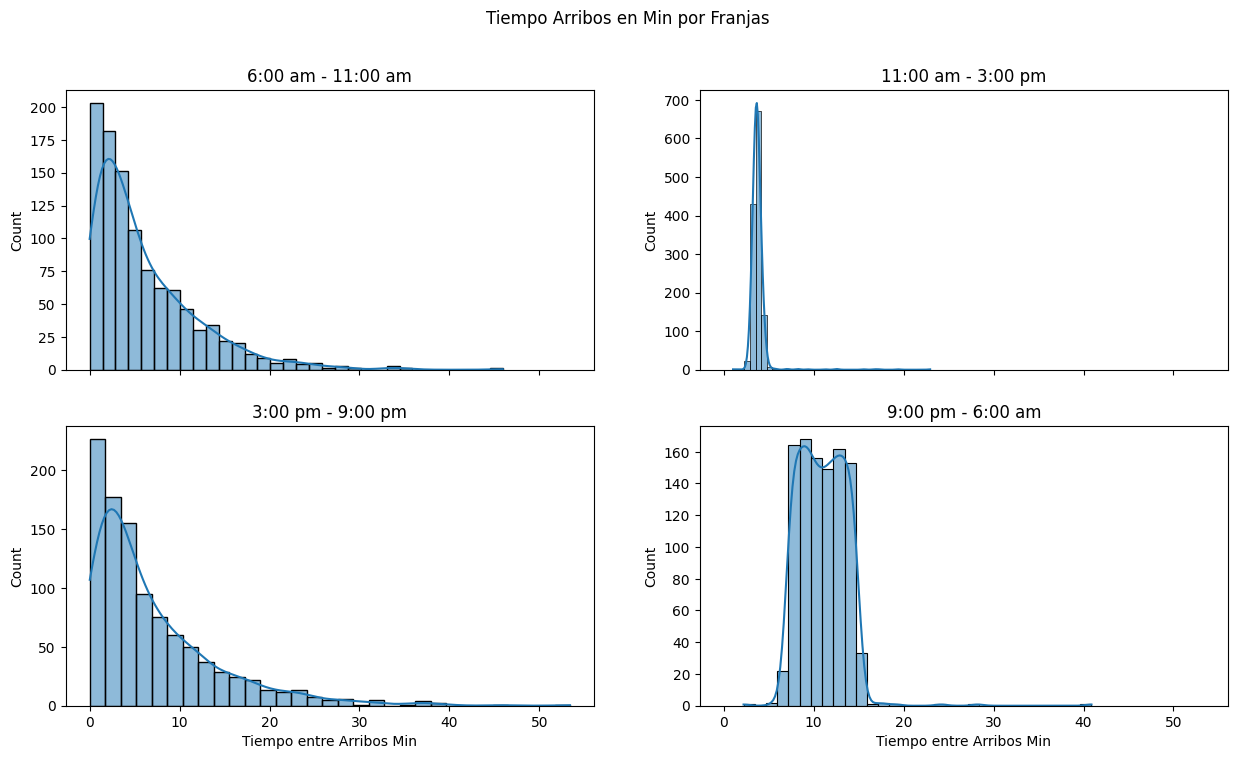

In [ ]:
AIM.histogramas_tiempo_llegadas_aviones_franjas()

**1.3. Visualizaciones Q-Q Plot , P-P Plot y distribucion observada versus teorica por franjas: 6 am- 11 am**

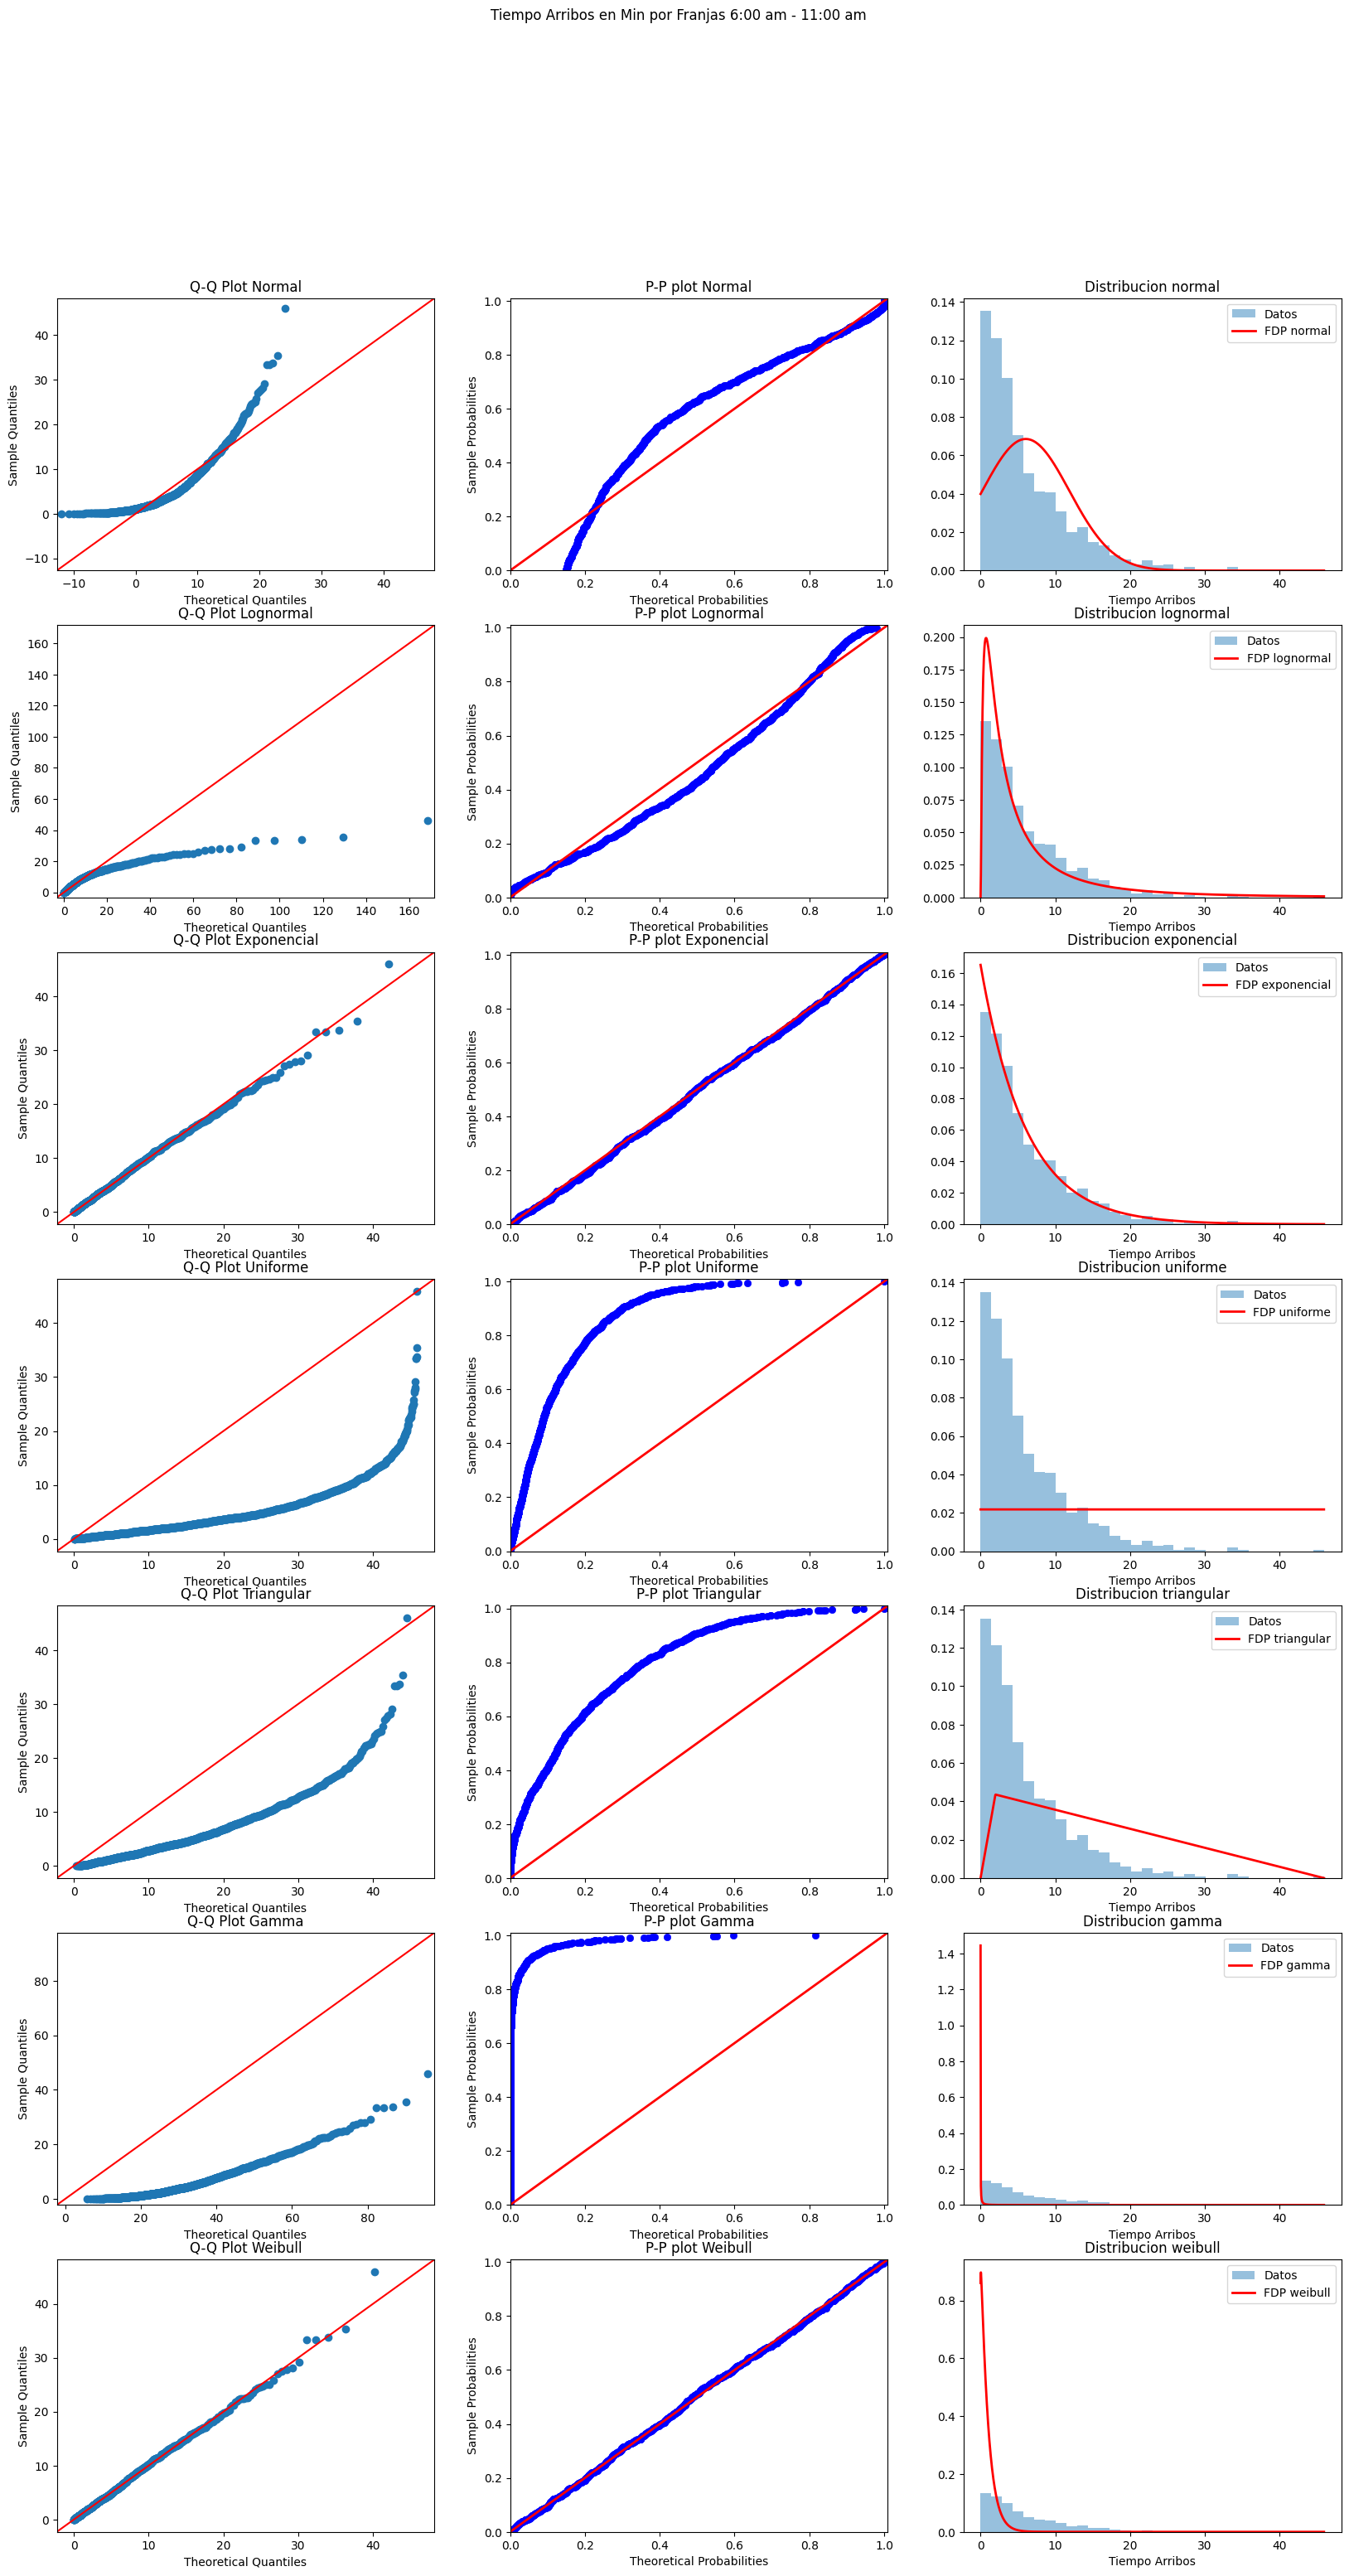

{'normal': {'media': 6.054550987890376, 'desvesta': 5.817594707503694}, 'lognormal': {'media': 1.2517153587480148, 'desvesta': 1.2484059611884557}, 'exponencial': {'tasa': 6.054550987890376}, 'uniforme': {'minimo': 0.0035499999999999998, 'maximo': 45.93255}, 'triangular': {'minimo': 0.0035499999999999998, 'moda': 1.9891166666666666, 'maximo': 45.93255}, 'gamma': {'media': 6.054550987890376, 'varianza': 33.84440818077499}, 'weibull': {'forma': 1.03155564197949, 'escala': 6.131169715335696}}


In [ ]:
resultado=AIM.visualizacion_observado_teorico_por_franjas("6:00 am - 11:00 am")
print(resultado)

**1.4. Prueba de bondad de ajuste Chi-Cuadrado para la franja 6 am-11 am**

In [2]:
from funcioneschicuadrado_continuas import*
datos=df[df['Franja Horaria']== "6:00 am - 11:00 am"]['Tiempo entre Arribos Min']
chi_square_exponential_goodness_of_fit(datos,tasa="estimado",r=1)


Parámetro estimado: Tasa = 0.16516501421824448
Chi-squared statistic: 198.0095556551723
p-value: 0.6611221871041646


In [3]:
chi_square_weibull_goodness_of_fit(datos,forma="estimado",escala="estimado",r=2)

Parámetro estimado: Escala = 6.131169715335696
Parámetro estimado: Forma = 1.03155564197949
Chi-squared statistic: 226.9859507467217
p-value: 0.1507257993766501


**1.5. Visualizaciones Q-Q Plot , P-P Plot y distribucion observada versus teorica por franjas: 11 am- 3 pm**

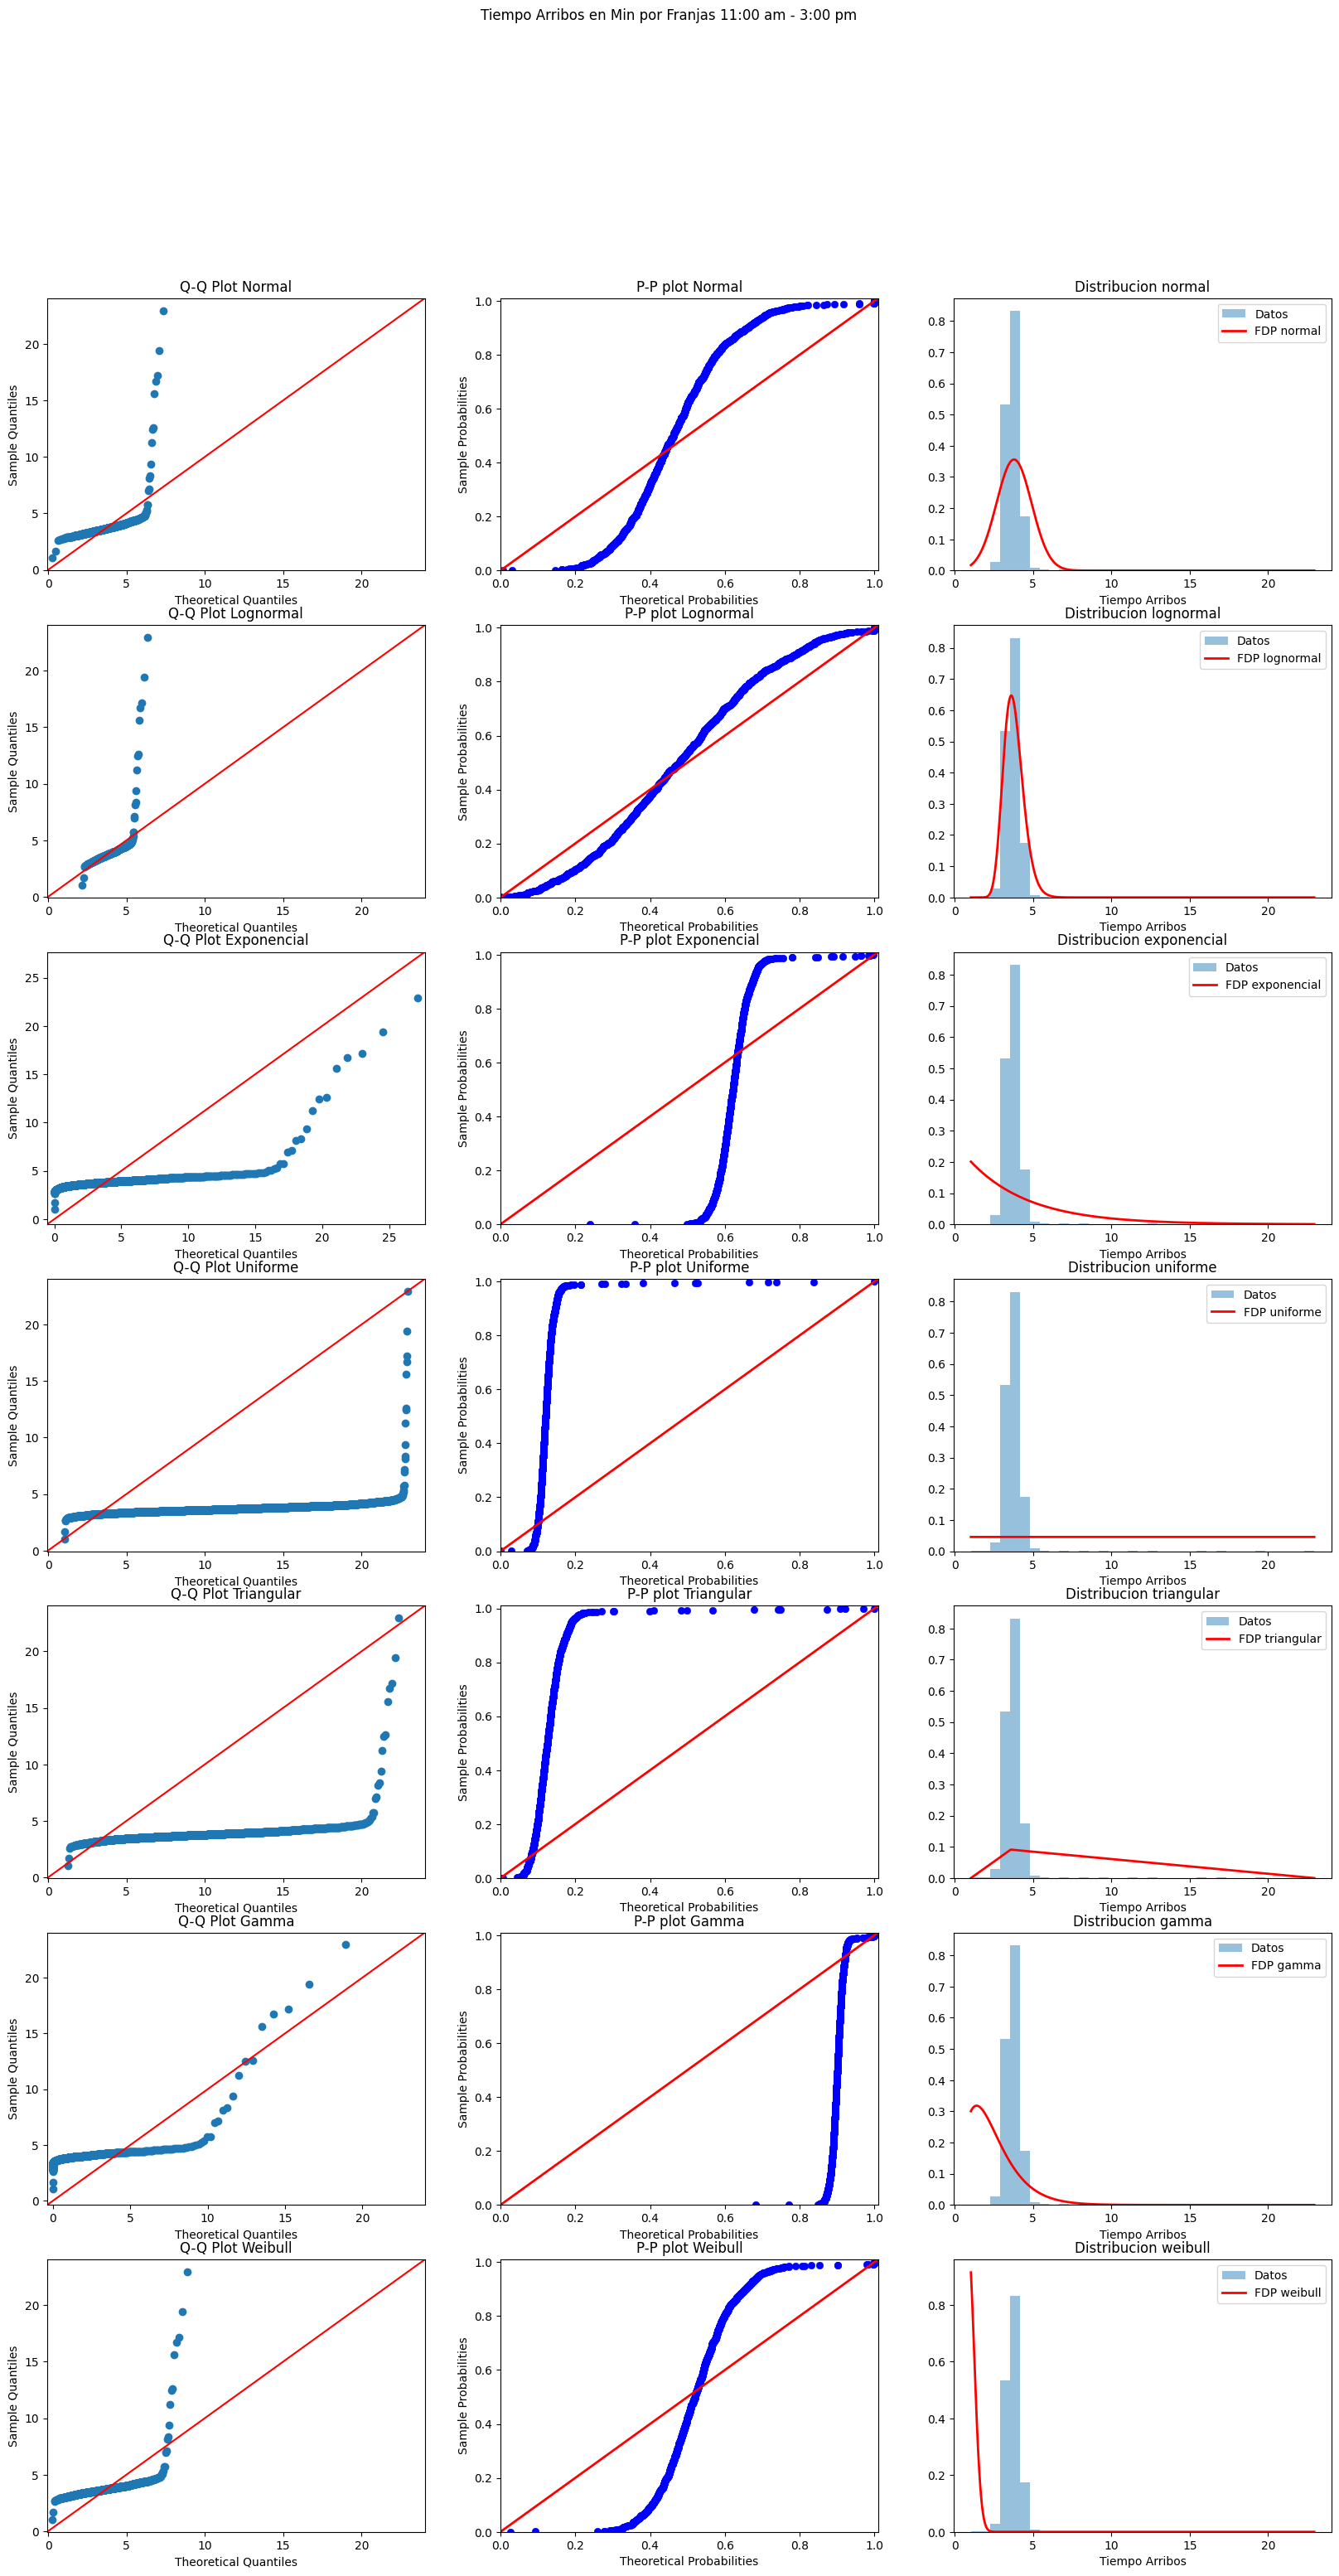

{'normal': {'media': 3.7880701060253426, 'desvesta': 1.121107640431049},
 'lognormal': {'media': 1.3126884223768747, 'desvesta': 0.1682738789373307},
 'exponencial': {'tasa': 3.7880701060253426},
 'uniforme': {'minimo': 1.0352833333333333, 'maximo': 22.948566666666668},
 'triangular': {'minimo': 1.0352833333333333,
  'moda': 3.5780499999999997,
  'maximo': 22.948566666666668},
 'gamma': {'media': 3.7880701060253426, 'varianza': 1.256882341432874},
 'weibull': {'forma': 2.586022917059287, 'escala': 4.149539229972704}}

In [ ]:
AIM.visualizacion_observado_teorico_por_franjas("11:00 am - 3:00 pm")

**1.6. Prueba de bondad de ajuste Chi-Cuadrado para la franja 11 am-3 pm**

In [5]:
datos = df[df['Franja Horaria']== "11:00 am - 3:00 pm"]['Tiempo entre Arribos Min']
chi_square_lognormal_goodness_of_fit(datos,media="estimado",desvesta="estimado",r=2)


Parámetro estimado (lognormal asociada): Media = 1.3126884223768747
Parámetro estimado (lognormal asociada): Desviación Estándar = 0.1682738789373307
Chi-squared statistic: 656.3444530643909
p-value: 0.0


In [ ]:
chi_square_normal_goodness_of_fit(datos,media="estimado",desvesta="estimado",r=2)

Parámetro estimado: Media = 3.7880701060253426
Parámetro estimado: Desviación Estándar = 1.121107640431049
Chi-squared statistic: 1695.5593000335039
p-value: 0.0


**1.7. Visualizaciones Q-Q Plot , P-P Plot y distribucion observada versus teorica por franjas: 3 pm- 9 pm**

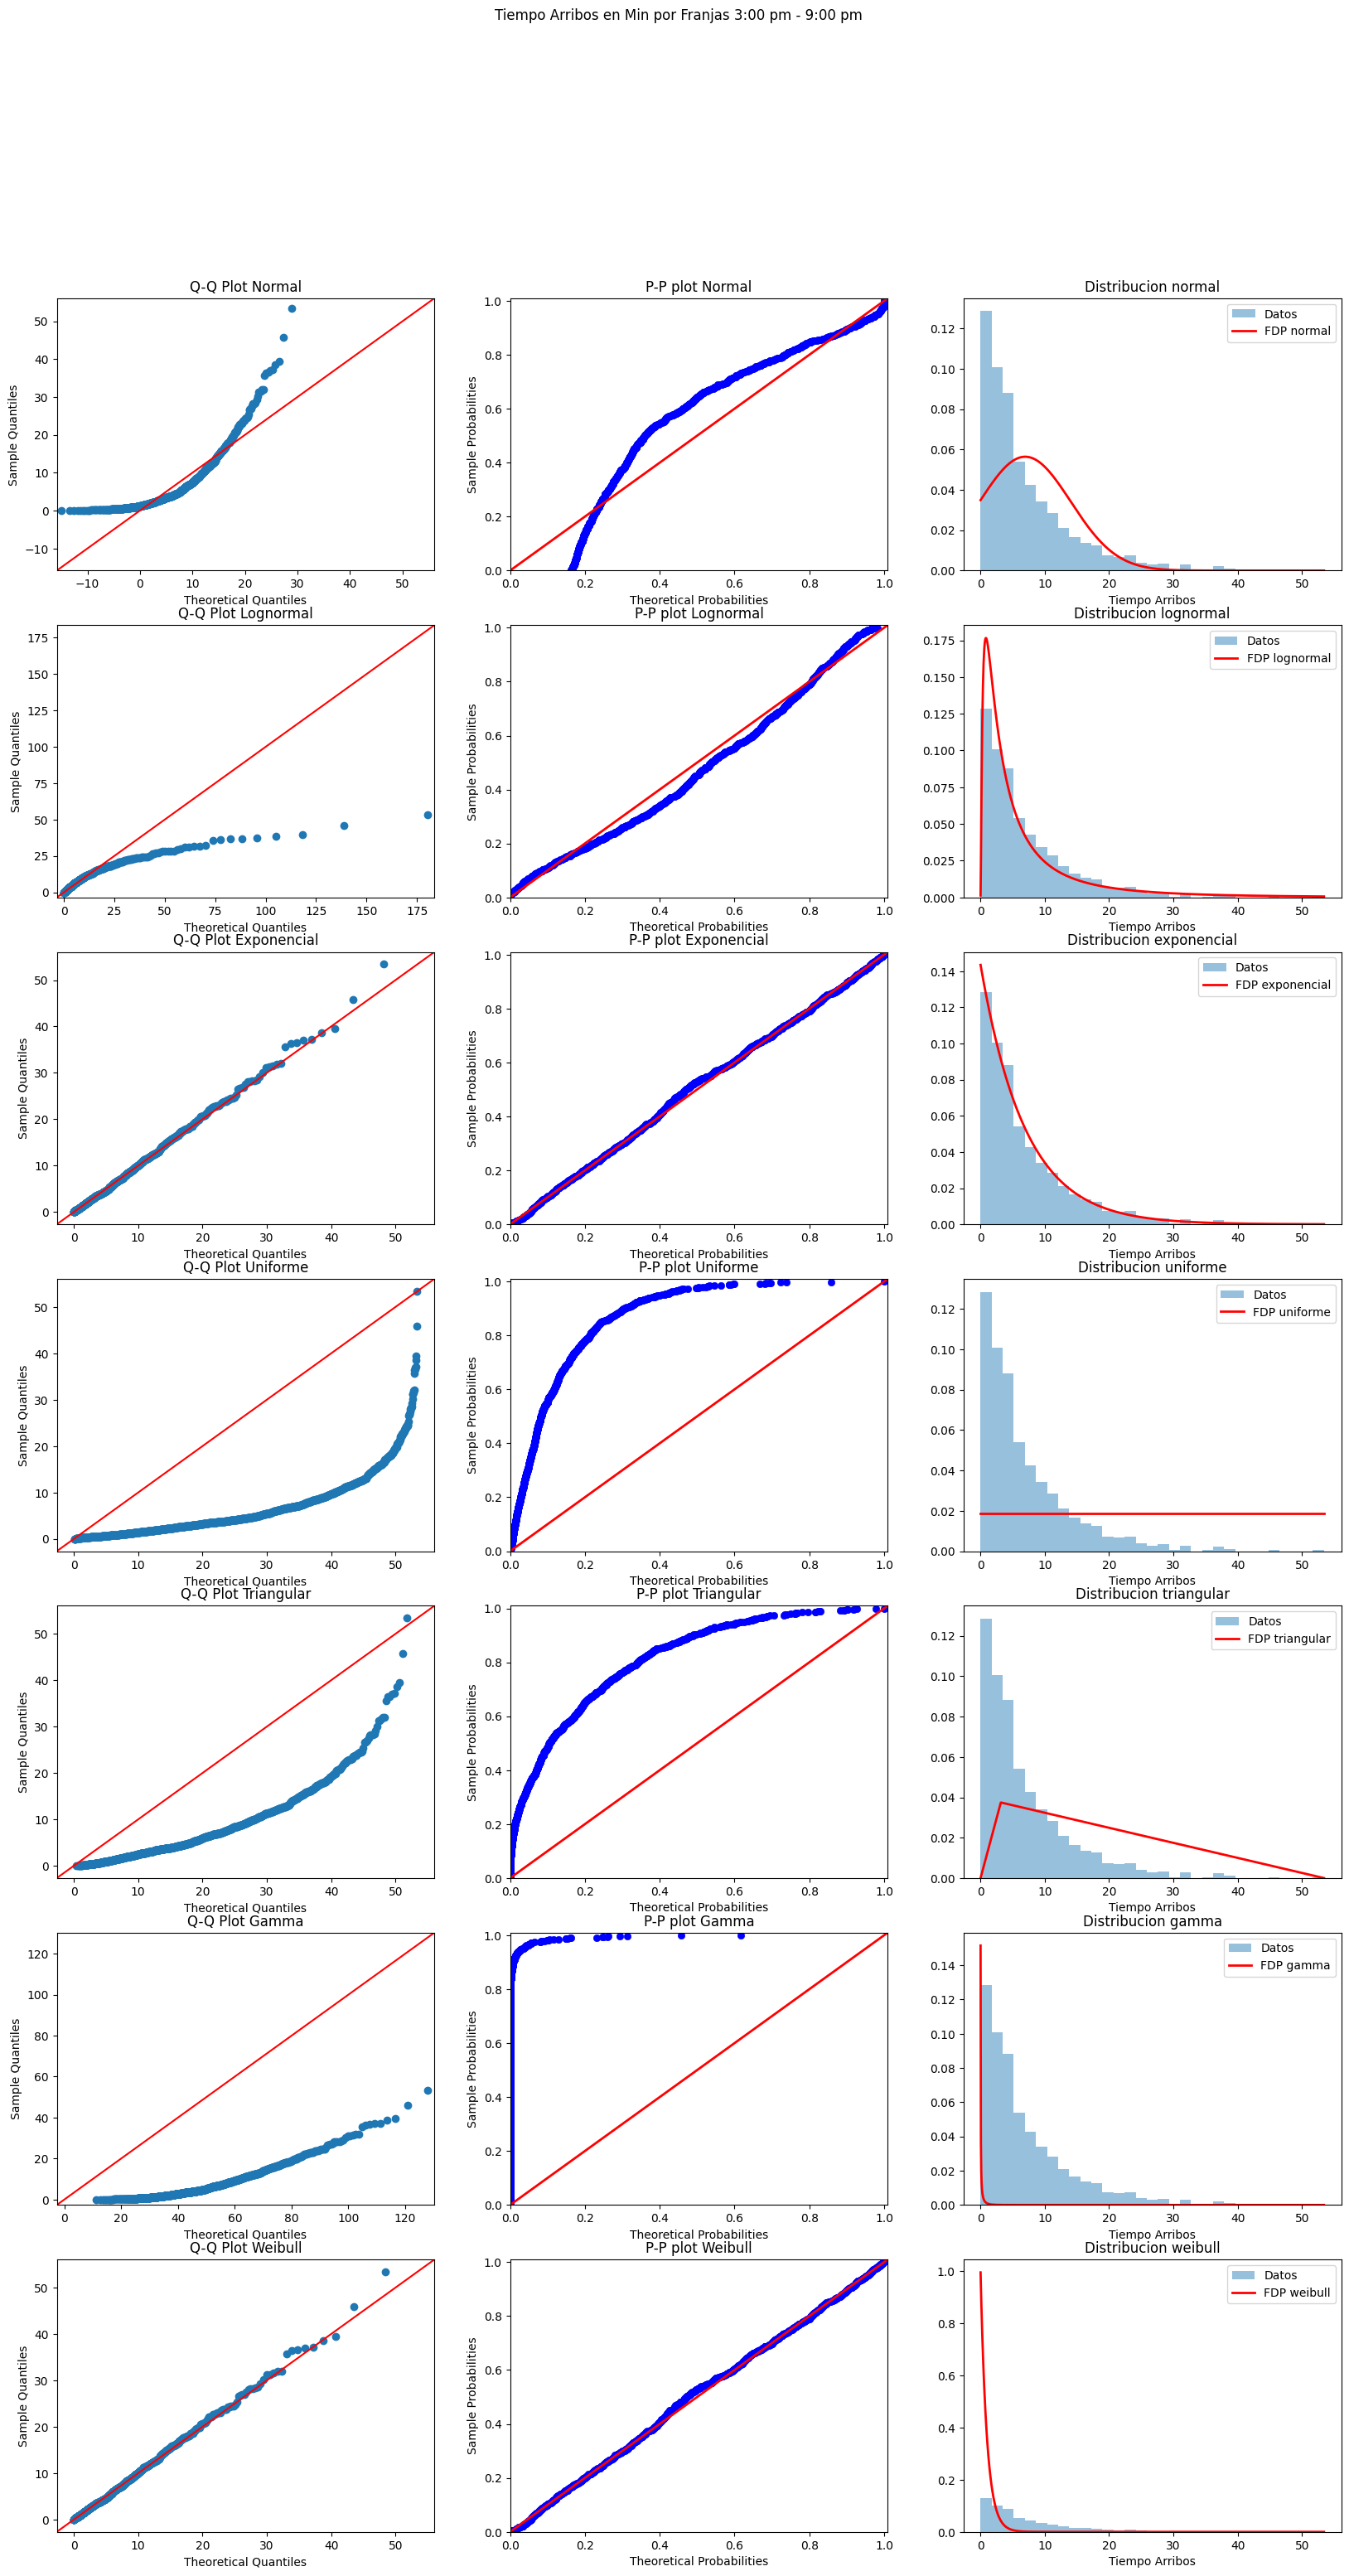

{'normal': {'media': 6.952127195559909, 'desvesta': 7.074853678654444},
 'lognormal': {'media': 1.3670338414458096, 'desvesta': 1.2357034173948651},
 'exponencial': {'tasa': 6.952127195559909},
 'uniforme': {'minimo': 0.017816666666666665, 'maximo': 53.4105},
 'triangular': {'minimo': 0.017816666666666665,
  'moda': 3.1682833333333336,
  'maximo': 53.4105},
 'gamma': {'media': 6.952127195559909, 'varianza': 50.05355457437032},
 'weibull': {'forma': 0.9960848727898852, 'escala': 6.9403331859979165}}

In [ ]:
AIM.visualizacion_observado_teorico_por_franjas("3:00 pm - 9:00 pm")

**1.8. Prueba de bondad de ajuste Chi-Cuadrado para la franja 3pm - 9 pm**

In [16]:
datos = df[df['Franja Horaria']== "3:00 pm - 9:00 pm"]['Tiempo entre Arribos Min']
chi_square_exponential_goodness_of_fit(datos,tasa="estimado",r=1)

Parámetro estimado: Tasa = 0.14384086652480504
Chi-squared statistic: 216.98824201570827
p-value: 0.22333319081337166


In [18]:
chi_square_lognormal_goodness_of_fit(datos,media="estimado",desvesta="estimado",r=2)

Parámetro estimado (lognormal asociada): Media = 1.3670338414458096
Parámetro estimado (lognormal asociada): Desviación Estándar = 1.2357034173948651
Chi-squared statistic: 312.692458374143
p-value: 7.399495436377634e-07


**1.9. Visualizaciones Q-Q Plot , P-P Plot y distribucion observada versus teorica por franjas: 9 pm- 6 am**

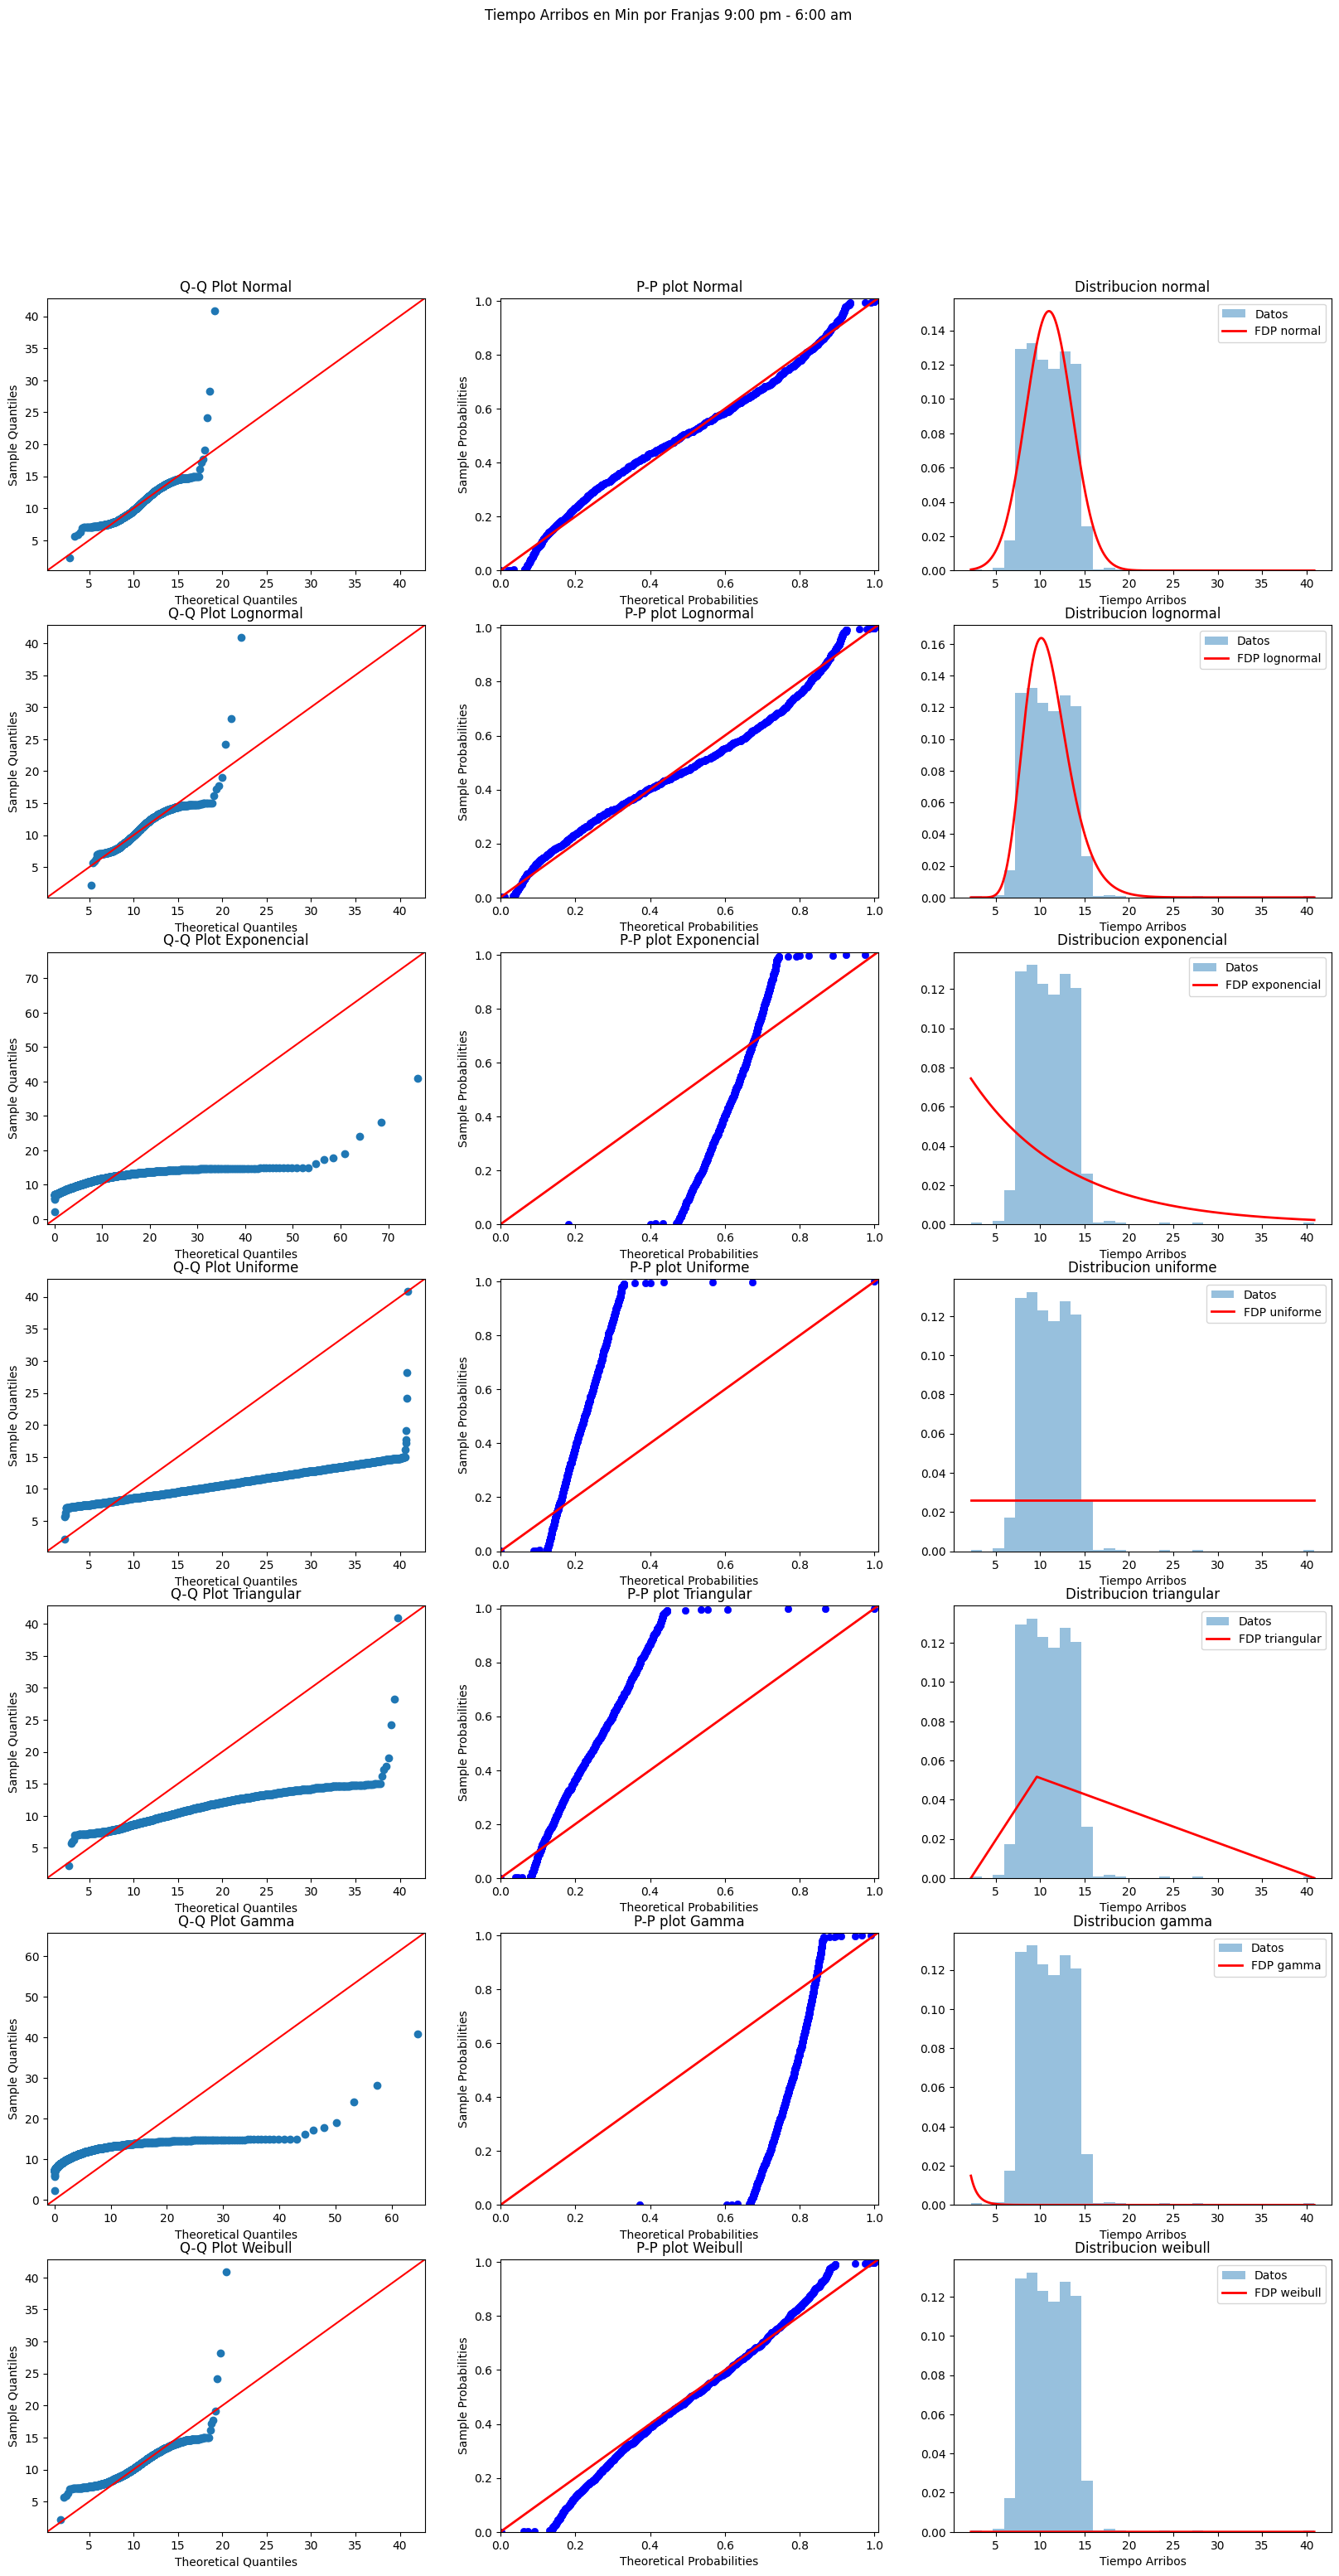

{'normal': {'media': 10.997025090134382, 'desvesta': 2.6386835479173025},
 'lognormal': {'media': 2.3704573876021735, 'desvesta': 0.23399730381243314},
 'exponencial': {'tasa': 10.997025090134382},
 'uniforme': {'minimo': 2.203616666666667, 'maximo': 40.88691666666667},
 'triangular': {'minimo': 2.203616666666667,
  'moda': 9.626650000000001,
  'maximo': 40.88691666666667},
 'gamma': {'media': 10.997025090134382, 'varianza': 6.962650866049443},
 'weibull': {'forma': 3.6323313048883916, 'escala': 11.977735085223983}}

In [ ]:
AIM.visualizacion_observado_teorico_por_franjas("9:00 pm - 6:00 am")

**1.10. Prueba de bondad de ajuste Chi-Cuadrado para la franja 9 pm- 6 am**

In [10]:
datos = df[df['Franja Horaria']== "9:00 pm - 6:00 am"]['Tiempo entre Arribos Min']
chi_square_normal_goodness_of_fit(datos,media="estimado",desvesta="estimado",r=2)

Parámetro estimado: Media = 10.997025090134382
Parámetro estimado: Desviación Estándar = 2.6386835479173025
Chi-squared statistic: 476.05406125424537
p-value: 0.0


***1.11. Otros metodos para encontrar las distribuciones de las franjas que fueron rechazadas la hipotesis nula con CHi-Cuadrado ***

In [ ]:
from scipy import stats
import pandas as pd
import numpy as np
import tqdm
import inspect
import warnings
warnings.filterwarnings('ignore')

def seleccionar_distribuciones(familia='realall', verbose=True):
    '''
    Esta función selecciona un subconjunto de las distribuciones disponibles
    en scipy.stats

    Parameters
    ----------
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas

    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).

    Returns
    -------
    distribuciones: list
        listado con las distribuciones (los objetos) seleccionados.

    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.

    Notes
    -----
        Las distribuciones levy_stable y vonmises han sido excluidas por el momento.

    '''

    distribuciones = [getattr(stats,d) for d in dir(stats) \
                     if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]

    exclusiones = ['levy_stable', 'vonmises']
    distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]

    dominios = {
        'realall' : [-np.inf, np.inf],
        'realline': [np.inf,np.inf],
        'realplus': [0, np.inf],
        'real0to1': [0, 1],
        'discreta': [None, None],
    }

    distribucion = []
    tipo = []
    dominio_inf = []
    dominio_sup = []

    for dist in distribuciones:
        distribucion.append(dist.name)
        tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
        dominio_inf.append(dist.a)
        dominio_sup.append(dist.b)

    info_distribuciones = pd.DataFrame({
                            'distribucion': distribucion,
                            'tipo': tipo,
                            'dominio_inf': dominio_inf,
                            'dominio_sup': dominio_sup
                          })

    info_distribuciones = info_distribuciones \
                          .sort_values(by=['dominio_inf', 'dominio_sup'])\
                          .reset_index(drop=True)

    if familia in ['realall', 'realline', 'realplus', 'real0to1']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
        condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                    (info_distribuciones['dominio_sup'] == dominios[familia][1])
        info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)

    if familia in ['discreta']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']

    seleccion = [dist for dist in distribuciones \
                 if dist.name in info_distribuciones['distribucion'].values]


    if verbose:
        print("---------------------------------------------------")
        print("       Distribuciones seleccionadas                ")
        print("---------------------------------------------------")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(info_distribuciones)

    return seleccion


def comparar_distribuciones(x, familia='realall', ordenar='aic', verbose=True):
    '''
    Esta función selecciona y ajusta un subconjunto de las distribuciones
    disponibles en scipy.stats. Para cada distribución calcula los valores de
    Log Likelihood, AIC y BIC.

    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.

    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas

    ordenar : {'aic', 'bic'}
        criterio de ordenación de mejor a peor ajuste.

    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).

    Returns
    -------
    resultados: data.frame
        distribucion: nombre de la distribución.
        log_likelihood: logaritmo del likelihood del ajuste.
        aic: métrica AIC.
        bic: métrica BIC.
        n_parametros: número de parámetros de la distribución de la distribución.
        parametros: parámetros del tras el ajuste

    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.

    Notes
    -----

    '''

    distribuciones = seleccionar_distribuciones(familia=familia, verbose=verbose)
    distribucion_ = []
    log_likelihood_= []
    aic_ = []
    bic_ = []
    n_parametros_ = []
    parametros_ = []

    for i, distribucion in enumerate(distribuciones):

        print(f"{i+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")

        try:
            parametros = distribucion.fit(data=x)
            nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                 if not p=='x'] + ["loc","scale"]
            parametros_dict = dict(zip(nombre_parametros, parametros))
            log_likelihood = distribucion.logpdf(x, *parametros).sum()
            aic = -2 * log_likelihood + 2 * len(parametros)
            bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

            distribucion_.append(distribucion.name)
            log_likelihood_.append(log_likelihood)
            aic_.append(aic)
            bic_.append(bic)
            n_parametros_.append(len(parametros))
            parametros_.append(parametros_dict)

            resultados = pd.DataFrame({
                            'distribucion': distribucion_,
                            'log_likelihood': log_likelihood_,
                            'aic': aic_,
                            'bic': bic_,
                            'n_parametros': n_parametros_,
                            'parametros': parametros_,

                         })

            resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)

        except Exception as e:
            print(f"Error al tratar de ajustar la distribución {distribucion.name}")
            print(e)
            print("")

    return resultados

def plot_distribucion(x, nombre_distribucion, ax=None):
    '''
    Esta función superpone la curva de densidad de una distribución con el
    histograma de los datos.

    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.

    nombre_distribuciones : str
        nombre de una de las distribuciones disponibles en `scipy.stats`.

    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado

    Raises
    ------

    Notes
    -----
    '''

    distribucion = getattr(stats, nombre_distribucion)

    parametros = distribucion.fit(data=x)

    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                         if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))

    log_likelihood = distribucion.logpdf(x, *parametros).sum()

    aic = -2 * log_likelihood + 2 * len(parametros)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribucion.pdf(x_hat, *parametros)

    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))

    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5);
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribución')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    print('---------------------')
    print('Resultados del ajuste')
    print('---------------------')
    print(f"Distribución:   {distribucion.name}")
    print(f"Dominio:        {[distribucion.a, distribucion.b]}")
    print(f"Parámetros:     {parametros_dict}")
    print(f"Log likelihood: {log_likelihood}")
    print(f"AIC:            {aic}")
    print(f"BIC:            {bic}")

    return ax


def plot_multiple_distribuciones(x, nombre_distribuciones, ax=None):
    '''
    Esta función superpone las curvas de densidad de varias distribuciones
    con el histograma de los datos.

    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.

    nombre_distribuciones : list
        lista con nombres de distribuciones disponibles en `scipy.stats`.

    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado

    Raises
    ------

    Notes
    -----
    '''

    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))

    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribuciones')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')

    for nombre in nombre_distribuciones:

        distribucion = getattr(stats, nombre)

        parametros = distribucion.fit(data=x)

        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parametros_dict = dict(zip(nombre_parametros, parametros))

        log_likelihood = distribucion.logpdf(x, *parametros).sum()

        aic = -2 * log_likelihood + 2 * len(parametros)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribucion.pdf(x_hat, *parametros)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)

    ax.legend();

    return ax

**1.12 Ajuste y seleccion de distribucion para la franja 11: am - 3 pm**

In [ ]:
df_franja= df[df['Franja Horaria']== "11:00 am - 3:00 pm"]['Tiempo entre Arribos Min']
resultados = comparar_distribuciones(
                x=df_franja.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados


1/32 Ajustando distribución: cauchy
2/32 Ajustando distribución: crystalball
3/32 Ajustando distribución: dgamma
4/32 Ajustando distribución: dweibull
5/32 Ajustando distribución: exponnorm
6/32 Ajustando distribución: genextreme
7/32 Ajustando distribución: genhyperbolic
8/32 Ajustando distribución: genlogistic
9/32 Ajustando distribución: gennorm
10/32 Ajustando distribución: gumbel_l
11/32 Ajustando distribución: gumbel_r
12/32 Ajustando distribución: hypsecant
13/32 Ajustando distribución: johnsonsu
14/32 Ajustando distribución: kappa4
15/32 Ajustando distribución: laplace
16/32 Ajustando distribución: laplace_asymmetric
17/32 Ajustando distribución: loggamma
18/32 Ajustando distribución: logistic
19/32 Ajustando distribución: loguniform
20/32 Ajustando distribución: moyal
21/32 Ajustando distribución: nct
22/32 Ajustando distribución: norm
23/32 Ajustando distribución: norminvgauss
24/32 Ajustando distribución: pearson3
25/32 Ajustando distribución: powernorm
26/32 Ajustando distr

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,genhyperbolic,-781.734222,1573.468443,1599.276553,5,"{'p': -2.9035309754869902, 'a': 1.852291067155..."
1,t,-791.923203,1589.846406,1605.331272,3,"{'df': 2.803363460230985, 'loc': 3.67612623686..."
2,johnsonsu,-795.975590,1599.951180,1620.597668,4,"{'a': -0.4466290796549382, 'b': 1.111809677236..."
3,norminvgauss,-821.957151,1651.914303,1672.560791,4,"{'a': 0.3608049338322258, 'b': 0.2045750032691..."
4,skewcauchy,-894.737205,1795.474409,1810.959275,3,"{'a': 0.1938872590284077, 'loc': 3.58510702515..."
5,cauchy,-903.610033,1811.220066,1821.543310,2,"{'loc': 3.666205938468816, 'scale': 0.23247652..."
6,gennorm,-921.669699,1849.339399,1864.824265,3,"{'beta': 0.6879531516525736, 'loc': 3.68308341..."
7,laplace_asymmetric,-930.281163,1866.562326,1882.047192,3,"{'kappa': 0.6619844012237843, 'loc': 3.4923827..."
8,dweibull,-955.375408,1916.750815,1932.235681,3,"{'c': 0.8618239144988903, 'loc': 3.68543333333..."
9,exponnorm,-967.684391,1941.368782,1956.853648,3,"{'K': 1.7345855104069114, 'loc': 3.29992151120..."


---------------------
Resultados del ajuste
---------------------
Distribución:   t
Dominio:        [-inf, inf]
Parámetros:     {'df': 2.803363460230985, 'loc': 3.6761262368652257, 'scale': 0.3057211334483597}
Log likelihood: -791.9232030976204
AIC:            1589.846406195241
BIC:            1605.3312722040585


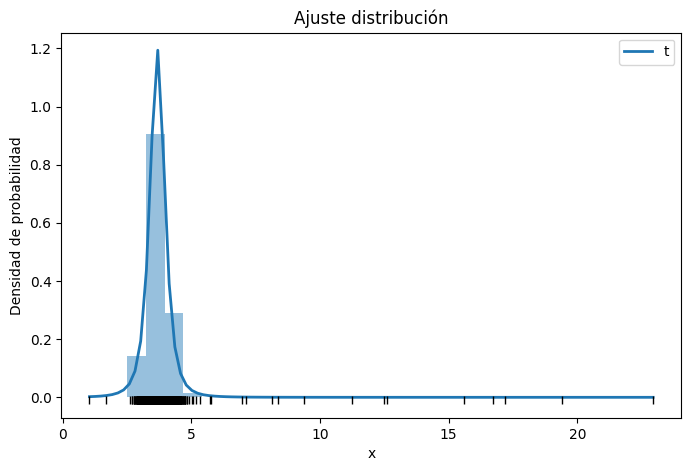

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

plot_distribucion(
    x=df_franja.to_numpy(),
    nombre_distribucion=resultados['distribucion'][1],
    ax=ax
);

**1.13 Prueba de bondad ajuste Kolmorogov Smirnov para la franja 11 am - 3 pm**

In [ ]:
params= ( 2.803363460230985,  3.6761262368652257,  0.3057211334483597)
AIM.ksetest_llegada_aviones_franja("11:00 am - 3:00 pm","t",params)

Estadística de prueba: 0.033831754728210706
Valor p: 0.10222952368571891
No se puede rechazar la hipótesis nula: los datos siguen la distribución teórica.


 **1.14 Ajuste y seleccion de distribucion para la franja 9pm - 6 am**

In [ ]:
df_franja= df[df['Franja Horaria']== "9:00 pm - 6:00 am"]['Tiempo entre Arribos Min']
resultados = comparar_distribuciones(
                x=df_franja.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados

1/32 Ajustando distribución: cauchy
2/32 Ajustando distribución: crystalball
3/32 Ajustando distribución: dgamma
4/32 Ajustando distribución: dweibull
5/32 Ajustando distribución: exponnorm
6/32 Ajustando distribución: genextreme
7/32 Ajustando distribución: genhyperbolic
8/32 Ajustando distribución: genlogistic
9/32 Ajustando distribución: gennorm
10/32 Ajustando distribución: gumbel_l
11/32 Ajustando distribución: gumbel_r
12/32 Ajustando distribución: hypsecant
13/32 Ajustando distribución: johnsonsu
14/32 Ajustando distribución: kappa4
15/32 Ajustando distribución: laplace
16/32 Ajustando distribución: laplace_asymmetric
17/32 Ajustando distribución: loggamma
18/32 Ajustando distribución: logistic
19/32 Ajustando distribución: loguniform
20/32 Ajustando distribución: moyal
21/32 Ajustando distribución: nct
22/32 Ajustando distribución: norm
23/32 Ajustando distribución: norminvgauss
24/32 Ajustando distribución: pearson3
25/32 Ajustando distribución: powernorm
26/32 Ajustando distr

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,nct,-2367.743964,4743.487929,4763.186379,4,"{'df': 22.95215785464608, 'nc': 5.934695444106..."
1,johnsonsu,-2369.079716,4746.159432,4765.857882,4,"{'a': -3.6295131538994045, 'b': 3.744466079407..."
2,exponnorm,-2370.383955,4746.767911,4761.541748,3,"{'K': 0.6570313619305821, 'loc': 9.61819188839..."
3,genhyperbolic,-2369.431075,4748.862149,4773.485211,5,"{'p': 5.161092965581498, 'a': 0.02891908435250..."
4,norminvgauss,-2371.170446,4750.340892,4770.039342,4,"{'a': 17.308323869011645, 'b': 12.565117722446..."
5,genlogistic,-2377.853078,4761.706155,4776.479992,3,"{'c': 5.2083355632861466, 'loc': 6.80961147953..."
6,dweibull,-2384.643925,4775.287849,4790.061687,3,"{'c': 1.4176533920421306, 'loc': 10.9669013857..."
7,genextreme,-2385.059203,4776.118406,4790.892243,3,"{'c': 0.04107764450010591, 'loc': 9.8355558090..."
8,skewnorm,-2387.029622,4780.059244,4794.833081,3,"{'a': 3.8087771695567536, 'loc': 7.71851467291..."
9,powernorm,-2388.724550,4783.449099,4798.222937,3,"{'c': 0.05901187644897213, 'loc': 7.0255430909..."


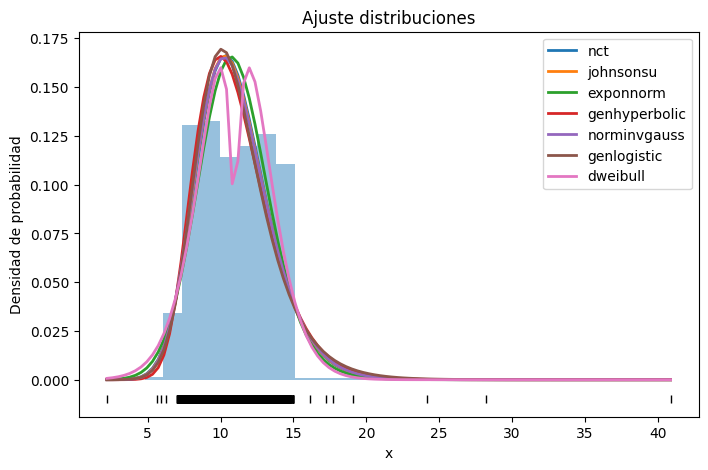

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

plot_multiple_distribuciones(
    x=df_franja.to_numpy(),
    nombre_distribuciones=resultados['distribucion'][:7],
    ax=ax
);

 **1.15 Prueba de bondad ajuste  para la franja 9pm - 6 am**

In [ ]:
parametros=(22.95215785464608,  5.9346954441066915,  -0.061281984612047785,  1.8010603460957233)
AIM.ksetest_llegada_aviones_franja("9:00 pm - 6:00 am","nct",parametros)

Estadística de prueba: 0.06450369804659073
Valor p: 0.0004020979315222856
Rechazar la hipótesis nula: los datos no siguen la distribución teórica.


In [ ]:
from scipy.stats import *
goodness_of_fit( nct, df_franja.to_numpy().flatten(), statistic='ksm',
                known_params={'df': 22.95215785464608, 'nc': 5.9346954441066915, 'loc': -0.061281984612047785, 'scale': 1.8010603460957233})

GoodnessOfFitResult(fit_result=  params: FitParams(df=22.95215785464608, nc=5.9346954441066915, loc=-0.061281984612047785, scale=1.8010603460957233)
 success: True
 message: 'The fit was performed successfully.', statistic=1.408951721596465, pvalue=0.0004, null_distribution=array([0.12897815, 0.09505225, 0.13749089, ..., 0.42694303, 0.02208597,
       0.0559513 ]))

In [ ]:
data = df_franja.copy()
def chi_square_nct_goodness_of_fit(data,df, nc, loc, scale,r=4):
  n = len(data)
  # Divide the data into k intervals
  k = math.floor(n/5)

  intervals = np.zeros(k+1)
  intervals = np.linspace(0, k*np.mean(data), k+1)
  expected_frequencies = [n * (nct.cdf(intervals[i+1], df=df, nc=nc, loc=loc, scale=scale)
                            - nct.cdf(intervals[i],  df=df, nc=nc, loc=loc, scale=scale)) for i in range(k)]

  # Calculate the observed frequencies for each interval
  observed_frequencies = np.zeros(k+1)
  observed_frequencies, _ = np.histogram(data, intervals)
      # Calculate the test statistic
  chi_squared = sum((observed_frequencies[i] - expected_frequencies[i])**2  for i in range(k - 1))

      # Calculate the degrees of freedom
  degrees_of_freedom = k - r - 1
  print(chi_squared)
      # Calculate the p-value
  p_value = 1 - chi2.cdf(chi_squared, degrees_of_freedom)

  respuesta = "Chi-squared statistic: "+ str(chi_squared) + "\np-value: " + str(p_value)

  return print(respuesta)

chi_square_nct_goodness_of_fit(data, df= 22.95215785464608,nc= 5.9346954441066915,loc= -0.061281984612047785, scale= 1.8010603460957233)


1694.3440274448576
Chi-squared statistic: 1694.3440274448576
p-value: 0.0


In [ ]:
from scipy.stats import *
goodness_of_fit( genlogistic, df_franja.to_numpy().flatten(), statistic='ks',
                known_params={'c': 5.2083355632861466, 'loc': 6.809611479532419, 'scale': 1.9828231855407195})

GoodnessOfFitResult(fit_result=  params: FitParams(c=5.2083355632861466, loc=6.809611479532419, scale=1.9828231855407195)
 success: True
 message: 'The fit was performed successfully.', statistic=0.07286951188335777, pvalue=0.0002, null_distribution=array([0.02089125, 0.01866439, 0.03296512, ..., 0.04445829, 0.02790655,
       0.03296913]))

In [ ]:
from scipy.stats import *
goodness_of_fit( dweibull, df_franja.to_numpy().flatten(), statistic='ks',
                known_params={'c': 1.4176533920421306, 'loc': 10.966901385740552, 'scale': 2.3025599632390996})

GoodnessOfFitResult(fit_result=  params: FitParams(c=1.4176533920421306, loc=10.966901385740552, scale=2.3025599632390996)
 success: True
 message: 'The fit was performed successfully.', statistic=0.053072706990829534, pvalue=0.007, null_distribution=array([0.02308152, 0.05109322, 0.02931189, ..., 0.02331844, 0.01781123,
       0.03185644]))

**2. ANALISIS ACTIVIDAD BIOMETRIA**

**2.1 Estadisticas descriptivas e histograma**

count    76203.000000
mean         1.335000
std          1.329447
min          0.000003
25%          0.386135
50%          0.924418
75%          1.861648
max         13.396196
Name: Tiempo de servicio (minutos), dtype: float64


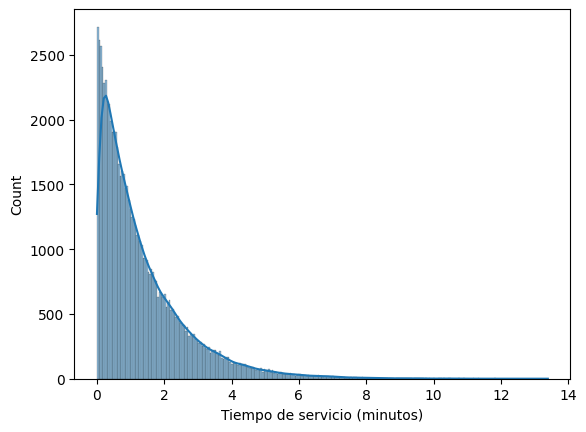

In [20]:
df_svc=AIM.tiempo_servicio_biometrico()
AIM.estadisticas_descript_tiempo_servicio_biometrico()
AIM.histograma_tiempo_servicio_biometrico()


**2.2 Visualizacion Q-Q Plot , P-P PLot y distribucion observada vs teorica**

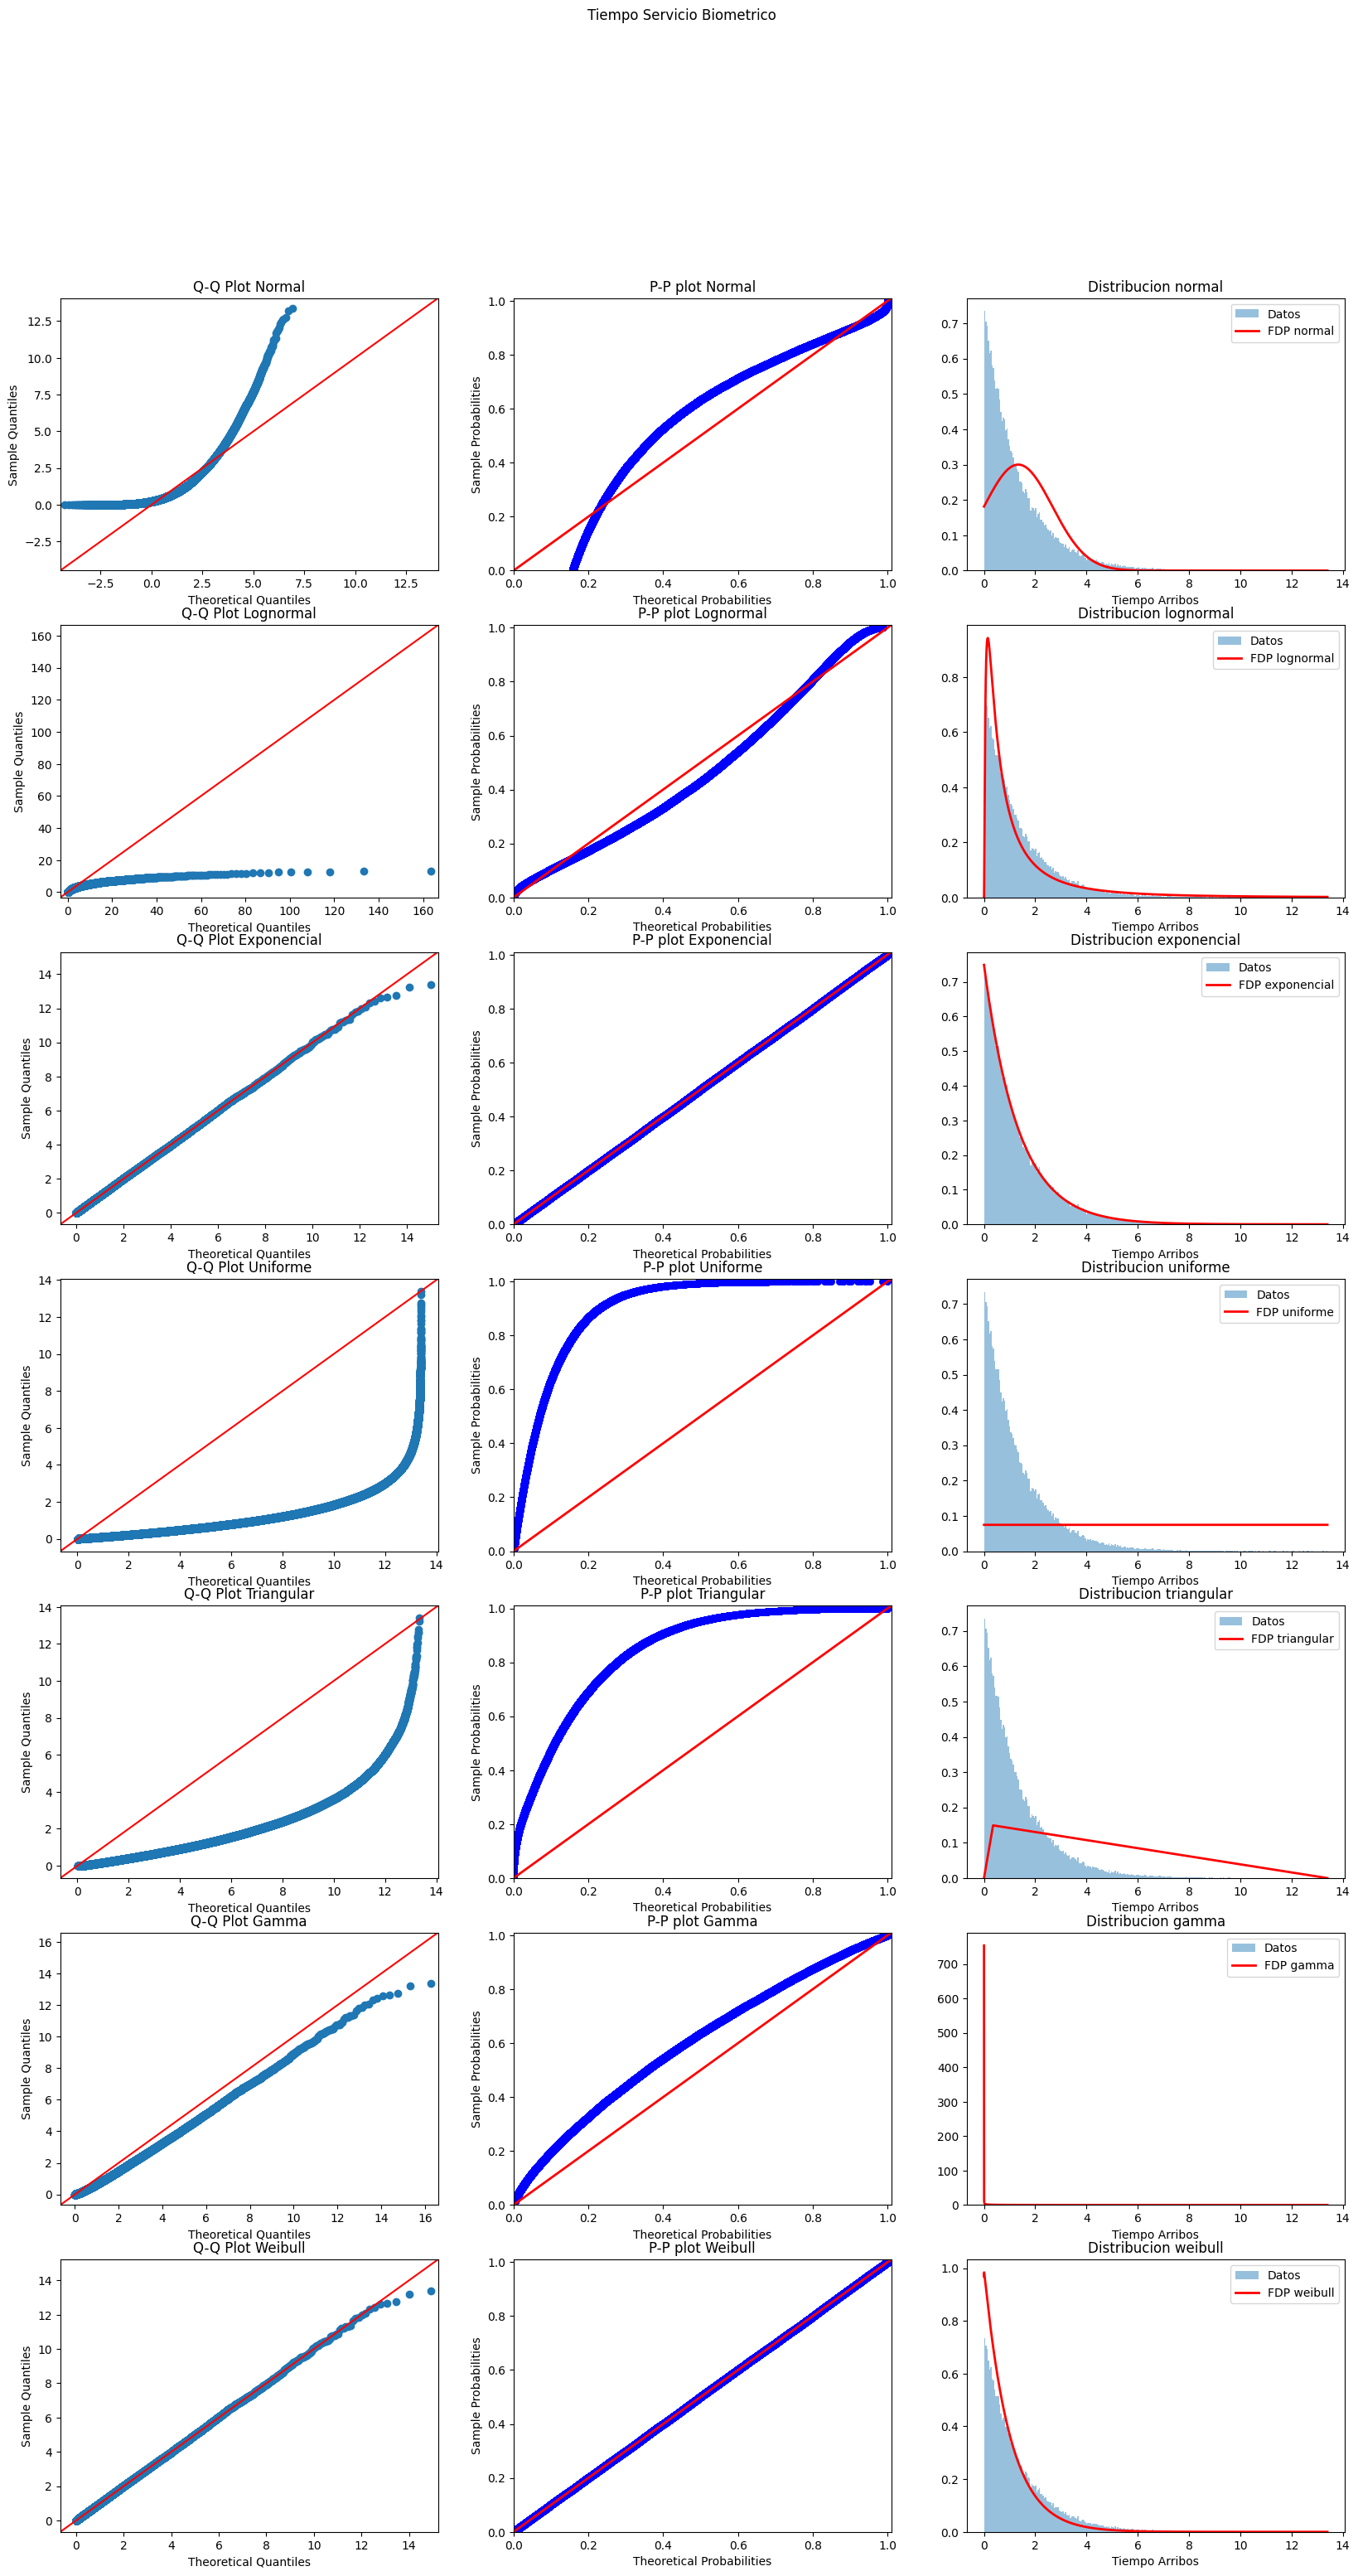

{'normal': {'media': 1.3350003637764654, 'desvesta': 1.329438449470138}, 'lognormal': {'media': -0.28596756733168804, 'desvesta': 1.2803043893885682}, 'exponencial': {'tasa': 1.3350003637764654}, 'uniforme': {'minimo': 2.645160719497484e-06, 'maximo': 13.396195505872463}, 'triangular': {'minimo': 2.645160719497484e-06, 'moda': 0.34999512395856236, 'maximo': 13.396195505872463}, 'gamma': {'media': 1.3350003637764654, 'varianza': 1.7674065909295642}, 'weibull': {'forma': 1.0027390493416182, 'escala': 1.3365523718394834}}


In [ ]:
resultados=AIM.visualizacion_observado_teorico_biometricos()
print(resultados)

**2.3 Prueba de bondad de ajuste con Chi-Cuadrado**

In [21]:
from funcioneschicuadrado_continuas import*
datos=df_svc['Tiempo de servicio (minutos)']
chi_square_exponential_goodness_of_fit(datos,tasa="estimado",r=1)

Parámetro estimado: Tasa = 0.7490634662983819
Chi-squared statistic: 15398.193417574805
p-value: 0.17924519457113275


In [22]:
chi_square_weibull_goodness_of_fit(datos,forma="estimado",escala="estimado",r=2)

Parámetro estimado: Escala = 1.3365523718394834
Parámetro estimado: Forma = 1.0027390493416182
Chi-squared statistic: 16116.963196923858
p-value: 3.697171411243261e-07


**3. CALCULO DE PROBABILIDADES DISCRETAS**

**3.1 Probabilidades por tipo de avion en el tiempo t**

In [ ]:
df= AIM.get_df_llegada_aviones()
df_aviones = AIM.get_df_llegada_aviones()

probabilidad_tipo_avion = df_aviones['Tipo de Avión'].value_counts(normalize=True)

print("Probabilidad de tipo Avipon en el tiempo t:")
print(probabilidad_tipo_avion)

Probabilidad de tipo Avipon en el tiempo t:
Mediano    0.599588
Grande     0.300480
Pequeño    0.099931
Name: Tipo de Avión, dtype: float64


**3.3 Probabilidades por tipo de avion en cada franja**

In [ ]:
franjas=["6:00 am - 11:00 am","11:00 am - 3:00 pm","3:00 pm - 9:00 pm","9:00 pm - 6:00 am"]
for franja in franjas:
  df= AIM.get_df_llegada_aviones()
  df= df[df["Franja Horaria"]==franja]
  print(f"Probabilidad de tipo Avion en franja {franja}:")
  probabilidad_tipo_avion = df['Tipo de Avión'].value_counts(normalize=True)
  print(probabilidad_tipo_avion)
  print("\n")



Probabilidad de tipo Avion en franja 6:00 am - 11:00 am:
Mediano    0.589866
Grande     0.307839
Pequeño    0.102294
Name: Tipo de Avión, dtype: float64


Probabilidad de tipo Avion en franja 11:00 am - 3:00 pm:
Mediano    0.612878
Grande     0.293251
Pequeño    0.093871
Name: Tipo de Avión, dtype: float64


Probabilidad de tipo Avion en franja 3:00 pm - 9:00 pm:
Mediano    0.588639
Grande     0.305583
Pequeño    0.105779
Name: Tipo de Avión, dtype: float64


Probabilidad de tipo Avion en franja 9:00 pm - 6:00 am:
Mediano    0.603736
Grande     0.296952
Pequeño    0.099312
Name: Tipo de Avión, dtype: float64




**3.3 Probabilidades por tipo de pasajero en el tiempo t**

In [ ]:

df_pasaj = AIM.get_df_pasajeros()
# Calcular la probabilidad de cada tipo de pasaporte
probabilidad_tipo_pasaporte = df_pasaj['Tipo de pasaporte'].value_counts(normalize=True)

print(probabilidad_tipo_pasaporte)


Extranjero                0.550978
Nacional no biométrico    0.298877
Nacional biométrico       0.150145
Name: Tipo de pasaporte, dtype: float64


**3.3 Probabilidades por pasajero/maleta en el tiempo t**

In [ ]:
df_pasaj = AIM.get_df_pasajeros()

# Calcular la probabilidad de que el pasajero haya viajado con maleta
probabilidad_con_maleta = df_pasaj['¿Lleva maleta?'].value_counts(normalize=True)

print(probabilidad_con_maleta)


Sí    0.733263
No    0.266737
Name: ¿Lleva maleta?, dtype: float64


**3.4 Probabilidades por tipo pasajero en el tiempo t**

In [ ]:
df_pasaj = AIM.get_df_pasajeros()

# Calcular la probabilidad de que el pasajero haya viajado con maleta
probabilidad_tipo_pasaj = df_pasaj['Tipo de pasaporte'].value_counts(normalize=True)

print(probabilidad_tipo_pasaj)

Extranjero                0.550978
Nacional no biométrico    0.298877
Nacional biométrico       0.150145
Name: Tipo de pasaporte, dtype: float64
